In [35]:
!pip install transformers

In [15]:
import re
import torch
from torch import nn
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from transformers import AdamW
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.utils.data import RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score
import pandas as pd
from matplotlib import pyplot as plt
from nltk.tokenize import WordPunctTokenizer
import re
from bs4 import BeautifulSoup
import itertools

In [16]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: Tesla T4


In [28]:
MAX_LENGTH = 100
MODEL = 'bert-base-uncased'
TRAIN_TEST_SPLIT = 0.75
BATCH_SIZE = 32
LEARNING_RATE = 3e-5
EPOCHS = 2

In [18]:
def tweet_cleaner(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)

    tok = WordPunctTokenizer()
    pat1 = r'@[A-Za-z0-9]+'
    pat2 = r'https?://[A-Za-z0-9./]+'

    try:
        text = text.decode("utf-8-sig").replace(u"\ufffd",
                                                 "?")
    except:
        text = text

    # replace consecutive non-ASCII characters with a space
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    # remove emojis from tweet
    text = emoji_pattern.sub(r'', text)

    # HTML encoding
    text = BeautifulSoup(text,
                         'lxml')
    text = text.get_text()

    # removing @ mentions
    text = re.sub(pat1, '', text)

    # Removing URLs
    text = re.sub(pat2, '', text)

    # Fix misspelled words
    text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(
        text))  # checking that each character should occur not more than 2 times in every word

    # Tokenizing ,change cases & join together to remove unneccessary white spaces
    text_list = tok.tokenize(text.lower())
    text = (" ".join(text_list)).strip()

    return text

In [24]:
def get_data():
    train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
    test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

    train_df.drop('keyword', inplace=True, axis=1)
    train_df.drop('location', inplace=True, axis=1)

    test_df.drop('keyword', inplace=True, axis=1)
    test_df.drop('location', inplace=True, axis=1)

    train_df['text_cleaned'] = list(map(lambda x: tweet_cleaner(x), train_df['text']))
    test_df['text_cleaned'] = list(map(lambda x: tweet_cleaner(x), test_df['text']))

    return train_df, test_df

In [20]:
def tokenize(tokenizer, data):
    input_ids = []
    attention_masks = []

    for sentence in data:
        encoded_dict = tokenizer.encode_plus(
            sentence,  # Sentence to encode.
            add_special_tokens=True,
            padding="max_length",
            max_length=MAX_LENGTH,  # Pad & truncate all sentences.
            truncation=True,
            return_attention_mask=True,  # Construct attn. masks.
            return_tensors='pt',  # Return pytorch tensors.
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    return input_ids, attention_masks

In [21]:
tokenizer = BertTokenizer.from_pretrained(MODEL)

In [22]:
model = BertForSequenceClassification.from_pretrained(MODEL, num_labels=2,
                                                      output_attentions=False, output_hidden_states=False)
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [25]:
train_df, test_df = get_data()

train_data = train_df['text_cleaned'].values
train_labels = torch.tensor(train_df['target'].values).to(device)

/tmp/ipykernel_28/4057645839.py:28: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text,
/tmp/ipykernel_28/4057645839.py:28: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text,


In [29]:
input_ids, attention_masks = tokenize(tokenizer, train_data)
input_ids = torch.cat(input_ids, dim=0).to(device)
attention_masks = torch.cat(attention_masks, dim=0).to(device)

In [30]:
dataset = TensorDataset(input_ids, attention_masks, train_labels)
train_set, validation_set = random_split(dataset, [TRAIN_TEST_SPLIT, 1 - TRAIN_TEST_SPLIT])

train_dataloader = DataLoader(
    train_set,
    sampler=RandomSampler(train_set),
    batch_size=BATCH_SIZE)

validation_dataloader = DataLoader(
    validation_set,
    sampler=SequentialSampler(validation_set),
    batch_size=BATCH_SIZE)

In [31]:
len(train_dataloader)

179

In [32]:
loss_fn = nn.CrossEntropyLoss()

optimizer = AdamW(model.parameters(),
                  lr=LEARNING_RATE,
                  eps=1e-8)

# scheduler = get_linear_schedule_with_warmup(optimizer,
#                                             num_training_steps=len(train_dataloader) * EPOCHS,
#                                             num_warmup_steps=0)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [33]:
train_loss = []
validation_loss = []
accuracies = []
print("Train started")
for i in range(EPOCHS):
    print("")
    epoch_train_loss = 0
    epoch_validation_loss = 0
    epoch_validation_accuracy = 0

    for j, batch in enumerate(train_dataloader):
        inputs = batch[0]
        masks = batch[1]
        labels = batch[2]

        optimizer.zero_grad()

        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = loss_fn(outputs.logits, labels)

        loss.backward()
        optimizer.step()
#         scheduler.step()

        epoch_train_loss += loss.item()
        if (j + 1) % 10 == 0:
            print(f'Epoch: {i}  Batch: {j}  Loss: {epoch_train_loss / (j + 1)}')

    for batch in validation_dataloader:
        inputs = batch[0]
        masks = batch[1]
        labels = batch[2]

        with torch.no_grad():
            outputs = model(inputs)
            loss = loss_fn(outputs.logits, labels)

            predictions = torch.argmax(outputs.logits, dim=1)
            accuracy = accuracy_score(predictions.cpu().numpy(), labels.cpu().numpy())

            epoch_validation_loss += loss.item()
            epoch_validation_accuracy += accuracy

    train_loss.append(epoch_train_loss / len(train_dataloader))
    validation_loss.append(epoch_validation_loss / len(validation_dataloader))
    accuracies.append(epoch_validation_accuracy / len(validation_dataloader))

    print(f'======== Epoch {i} / {EPOCHS}  Train Loss: {train_loss[i]} ========')
    print(f'                          Validation Loss: {validation_loss[i]} ========')
    print(f'                           Validation Acc: {accuracies[i]} ========')

Train started

Epoch: 0  Batch: 9  Loss: 0.6257641106843949
Epoch: 0  Batch: 19  Loss: 0.5669540807604789
Epoch: 0  Batch: 29  Loss: 0.5432588775952657
Epoch: 0  Batch: 39  Loss: 0.5209632255136967
Epoch: 0  Batch: 49  Loss: 0.5047970628738403
Epoch: 0  Batch: 59  Loss: 0.48686288148164747
Epoch: 0  Batch: 69  Loss: 0.48647921425955637
Epoch: 0  Batch: 79  Loss: 0.4783468201756477
Epoch: 0  Batch: 89  Loss: 0.467784565852748
Epoch: 0  Batch: 99  Loss: 0.46656363680958746
Epoch: 0  Batch: 109  Loss: 0.46063820950009604
Epoch: 0  Batch: 119  Loss: 0.4602827421079079
Epoch: 0  Batch: 129  Loss: 0.45624940246343615
Epoch: 0  Batch: 139  Loss: 0.45551603361964227
Epoch: 0  Batch: 149  Loss: 0.4484411346912384
Epoch: 0  Batch: 159  Loss: 0.4451563745737076
Epoch: 0  Batch: 169  Loss: 0.44188721951316384
======== Epoch 0 / 2  Train Loss: 0.4392763635965699 ========
                          Validation Loss: 0.4305265049139659 ========
                           Validation Acc: 0.8276041666666

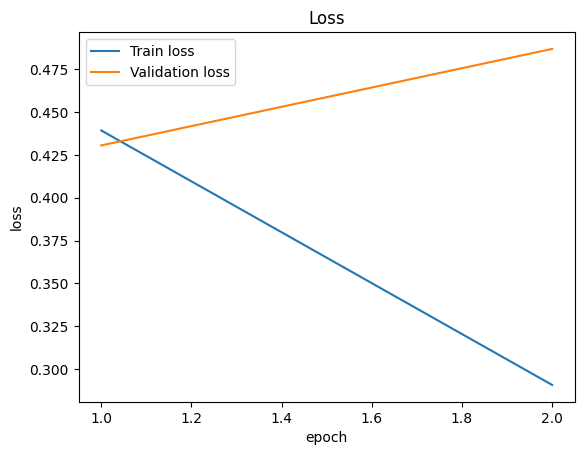

In [34]:
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')

epochs = torch.arange(1, EPOCHS + 1)
plt.plot(epochs, train_loss, label='Train loss')
plt.plot(epochs, validation_loss, label='Validation loss')
plt.legend()
plt.show()

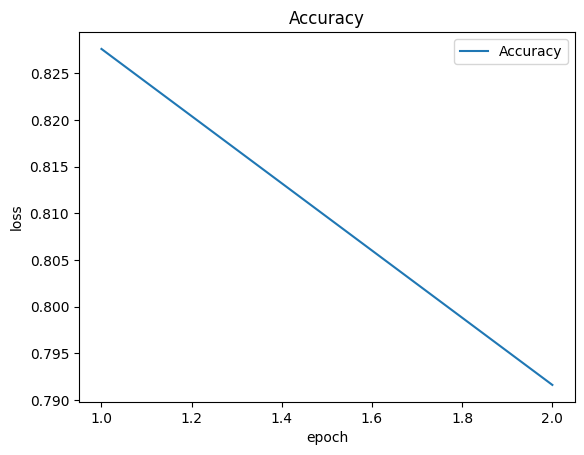

In [35]:
plt.clf()
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.plot(epochs, accuracies, label='Accuracy')
plt.legend()
plt.show()

In [64]:
test_data = test_df['text_cleaned'].values
input_ids, attention_masks = tokenize(tokenizer, test_data)
input_ids = torch.cat(input_ids, dim=0).to(device)
attention_masks = torch.cat(attention_masks, dim=0).to(device)

In [65]:
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=BATCH_SIZE)

In [66]:
model.eval()
labels = []
for batch in prediction_dataloader:
    inputs = batch[0]
    masks = batch[1]

    with torch.no_grad():
        outputs = model(inputs)

        predictions = torch.argmax(outputs.logits, dim=1)
        labels.append(predictions.cpu().numpy())

In [67]:
import numpy as np
labels = np.concatenate(labels, axis=0)

labels

array([1, 1, 1, ..., 1, 1, 1])

In [68]:
len(test_data)

3263

In [69]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission.head()
# labels

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [70]:
sample_submission["target"] = labels

In [73]:
sample_submission.to_csv("submission.csv", index=False)